
# Landsat 8 Geomedian Dashboard

Note: This notebook is a dashboard, check out this link to preview:
https://nbviewer.jupyter.org/github/GeoscienceAustralia/dea-notebooks/blob/master/Composite_generation/Landsat8_Geomedian_Dashboard.ipynb

__Background:__ [Landsat 8](https://landsat.usgs.gov/landsat-8) data is available from April 2013 onwards. The geometric median ([geomedian](http://ieeexplore.ieee.org/document/8004469/)) is a spatial median composite of satellite data that can be used to look at the statistically "average" behavior of an area summarising the chosen time interval. The geometric median preserves relationships between spectral bands - so instead of getting an "average" behaviour for each band, you get an overall measure of the central tendency that works spatially, temporally and spectrally.

__Before you run this notebook:__ This notebook uses the dea statistics module. You need to run "module load dea" in a terminal window and then launch jupyter notebooks in the same window so that your notebook can 'see' the stats module.

__What does this notebook do?:__ This notebook interactively creates a geomedian composite of Landsat 8 data. You can then save the data as a png image, netcdf and geotiff.

__Date:__ May 2018

__Authors:__ Bex Dunn, Vanessa Newey, Erin Telfer

### Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules and run the dashboard.

In [4]:
#import standard libraries
import datetime #for widget date validation
import fiona
import numpy as np
import os
import pandas as pd
import rasterio
import sys
import xarray as xr
from ipywidgets import interact #for widgets
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import rasterio.features
import shapely.geometry
from skimage import exposure #check if you still need this after you add external fns

#modules for datacube and dea stats
import datacube 
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube_stats.statistics import GeoMedian
from datacube.utils import geometry
# set datacube alias
dc = datacube.Datacube(app='dc-tcw and geomedian')

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#set global variables for widgets
global NBART_GM
global GEOM
global SHAPE_NAME
GEOM = None
SHAPE_NAME =None

### Select a shape file for your area of analysis
 - Shape file can be selected by __either__ choosing a file __or__ by drawing a polygon below
 - __Note:__ if area is larger than 20km x 20km or time period is long, notebook may run out of memory

In [5]:
#code to work with an input polygon
style = {'description_width': 'initial'}
shape_file = '/g/data1a/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/fels_sml.shp'
shape_file_text = widgets.Text(value=shape_file,placeholder='choose a file',
    description='path to shape file',
    style = {'description_width': 'initial'},                          
    disabled=False,
    layout=widgets.Layout(width='70%'))
def handle_shape_file(sender):
    shape_file=shape_file_text.value
shape_file_text.observe(handle_shape_file)
#display(shape_file_text)

### Use the select file button to choose a shape file

In [6]:
f = SelectFileButton()
def handle_file_selector(sender):
    shape_file_text.value = f.file
f.on_click(handle_file_selector)
display(widgets.HBox([shape_file_text,f],disabled=False))


### Use the check shapefile button to check if the chosen shapefile is valid

In [7]:
button =widgets.Button(
    description='Check shapefile',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def on_button_clicked(b):
    #check whether shapefile is a valid shapefile and exists
    if not os.path.isfile(shape_file_text.value):
        print('this is not a shapefile')
    else:
        try:
            with fiona.open(shape_file_text.value, 'r') as input:
            # check that the file type is a shapefile
                if input.driver == 'ESRI Shapefile':
                    global GEOM
                    global SHAPE_NAME
                    GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file_text.value)
                    print ("Specified file is a shapefile!")
                else:
                    print ("NOT a shapefile!")
        except:
            print ("NOT a shapefile!")

    #shapes = fiona.open(shape_file)
button.on_click(on_button_clicked)
display(button)

Button(description='Check shapefile', style=ButtonStyle(), tooltip='Click me')

### Alternatively, draw a polygon on the map below
After the polygon is drawn, select 'DrawnPolygon' below figure to use the polygon.

In [8]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)


from traitlets import link
import ipywidgets as widgets
from datacube.utils import geometry
#center = [-12.543839666237682, 131.08474731445315]
center =[-20.0183,145.3134]
zoom = 10


m = Map(center=center, zoom=zoom,layout=dict(width='400px', height='400px'))

#Let's draw a second map 

m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


# Now create the DrawControls and add it to the Maps using add_control. 
# We also register handlers for draw events. These will fire when a polygon is drawn created, edited or deleted 
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path, 
# along with its embedded style.

draw_control = DrawControl(polyline={})
draw_control2 = DrawControl(polygon={'shapeOptions': {'color': '#0000FF'}}, polyline={})
def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

#use_map_geom_button = widgets.Button(description="Use Drawn Geom")

use_map_geom_button = widgets.ToggleButtons(
    options=['Shapefile', 'DrawnPolygon'],
    description='Geometry Used for Datacube Query:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Use Shapefile Specified for the DC query', 'Use Polygon Drawn on the Map for the DC query'],
#     icons=['check'] * 3
)

def on_map_button_click(b):
    global GEOM
    global SHAPE_NAME
    #Leaflet return geometry in EPSG:4326
    geom_crs = geometry.CRS('EPSG:4326') 
    if use_map_geom_button.value == "Shapefile":
        GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file_text.value)
    else:
        try:
            GEOM=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
            SHAPE_NAME = "drawn_polygon"
        except:
            print("Draw a polygon first.")

use_map_geom_button.on_trait_change(on_map_button_click)


from ipywidgets import HBox, VBox
h_box= HBox([m,m2])

VBox([h_box,use_map_geom_button])

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:89: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead


### Fill in boxes to select time period of interest
Press the 'Check dates' button to check that the time period is valid

In [9]:
#Set a standard time range for people to change as desired
start_of_epoch = '2013-05-01'
end_of_epoch =  '2013-10-31'

#create a date picker widget for the start date
from_date_picker = widgets.Text(value=start_of_epoch,
                                placeholder='update this field YYYY-MM-DD',
    description='start date',
    disabled=False)

#define a function to check the start date
def handle_from_date(sender):
    '''takes the start of epoch date from the date picker and checks it is in the 
    correct format'''
    start_of_epoch=from_date_picker.value
    validate(start_of_epoch)
    
#when you press enter this runs the event handler (handle_from_date)    
from_date_picker.on_submit(handle_from_date)

#create a date picker widget for the end date
to_date_picker = widgets.Text(value = end_of_epoch,
                              placeholder='update this field YYYY-MM-DD',
    description='end date',
    disabled=False)

def handle_to_date(sender):
    '''takes the end of epoch date from the date picker and checks it is in the 
    correct format'''
    end_of_epoch = to_date_picker.value
    validate(end_of_epoch)
    
#when you press enter this runs the event handler (handle_to_date)    
to_date_picker.on_submit(handle_to_date)

#make a validation button to validate the dates
#first write the function the button runs
def validate(date_text):
    '''this function checks to see whether your text is year-month-day formatted'''
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
        return True    
    except ValueError:
        return False
    
#make the button run the function to check the dates
button_epoch =widgets.Button(
    description='Check dates',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

#This widget prints whether or not your start date is valid
starttextwidget = widgets.Label(
value='Is my start date valid?'
)

#This widget prints whether or not your end date is valid
endtextwidget = widgets.Label(
value='Is my end date valid?'
)

#this is the event handler for when you click on the button
def on_button_end_epoch_clicked(button):
    '''check whether the dates are in the format we need'''
    if not validate(to_date_picker.value):
        endtextwidget.value = ('Incorrect data format, should be YYYY-MM-DD')
    else:
        validate(to_date_picker.value)
        endtextwidget.value = ('End date is valid')
        
 
    if not validate(from_date_picker.value):
        starttextwidget.value = ('Incorrect data format, should be YYYY-MM-DD')
    else:
        validate(from_date_picker.value)
        starttextwidget.value = ('Start date is valid')
        start_of_epoch = from_date_picker.value
    
    
button_epoch.on_click(on_button_end_epoch_clicked)

#display widgets next to each other
end_hbox = widgets.HBox([to_date_picker, endtextwidget])
start_hbox = widgets.HBox([from_date_picker, starttextwidget])
display(start_hbox,end_hbox)
display(button_epoch)

Button(description='Check dates', style=ButtonStyle(), tooltip='Click me')

### Load the data and calculate the geomedian

Push the 'Load and Calculate' button.
This may take a few minutes, please be patient. 

In [10]:
loadButton = widgets.Button(description="Load and Calculate")

def on_load_button_clicked(b):
    start_of_epoch = from_date_picker.value
    end_of_epoch = to_date_picker.value
    global GEOM
    global SHAPE_NAME
    if GEOM is None:
        GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(shape_file_text.value)

    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': GEOM,
    }

    sensor3_nbart, crs, affine=DEADataHandling.load_nbarx(dc,sensor='ls8', query=query)
    
    nbart=sensor3_nbart.sortby('time')
    #geomedian transform
    global NBART_GM
    NBART_GM=GeoMedian().compute(nbart)
    print("Geomedian calculated")

loadButton.on_click(on_load_button_clicked)
display(loadButton)

Button(description='Load and Calculate', style=ButtonStyle())

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain
Geomedian calculated


### Plot the geomedian composite in true color (RGB):

Button(description='Plot Geomedian', style=ButtonStyle())

<Figure size 432x288 with 0 Axes>

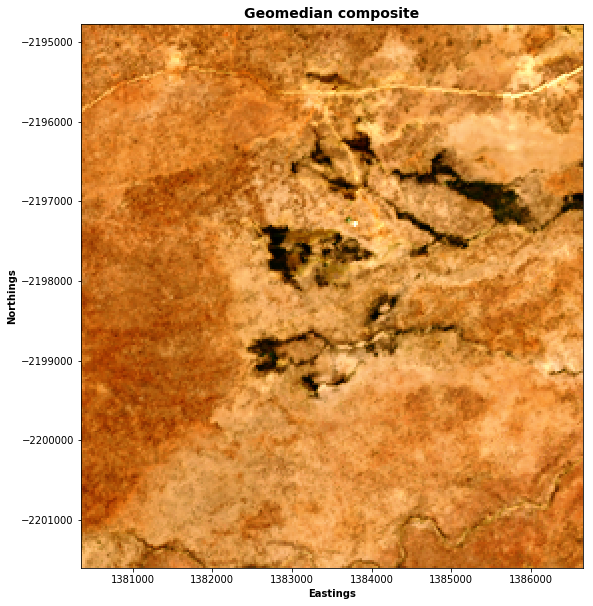

In [11]:
plotButton = widgets.Button(description="Plot Geomedian")
def on_plot_button_click(b):
    global NBART_GM
    plt.clf()
    DEAPlotting.three_band_image(NBART_GM, title='Geomedian composite', contrast_enhance=True)
plotButton.on_click(on_plot_button_click)
display(plotButton)

### Save as netcdf:

In [14]:
saveFileB = SaveFileButton()
def handle_file_selector(sender):
    filename =saveFileB.file
    global NBART_GM
    DEADataHandling.write_your_netcdf(NBART_GM,'nbart_gm',filename=filename, crs=NBART_GM.crs)
    print("saved netcdf ...check you added a .nc to the end of your filename..")
saveFileB.on_click(handle_file_selector)
display(saveFileB)


SaveFileButton(description='Save File As', icon='square-o', style=ButtonStyle(button_color='orange'))

### Save as GeoTiff:

In [15]:
saveFileB2 = SaveFileButton()
def handle_file_selector(sender):
    filename =saveFileB2.file
    global NBART_GM
    write_geotiff(filename, NBART_GM)
    print("saved geotiff, make sure you added a .tif to your filename")
saveFileB2.on_click(handle_file_selector)
display(saveFileB2)


SaveFileButton(description='Save File As', icon='square-o', style=ButtonStyle(button_color='orange'))

### Done. Check everything worked! 

## Check out many more Notebooks and functions: https://github.com/GeoscienceAustralia/dea-notebooks